# Weather Guess

### COhPy Challenge Issued Mar, 2016

> Andrew Kubera

# Part One

### Given a month, return list of dates in that month that COhPy has met 

Use the powerful **`dateutil`** module. This gives us a great `relativedelta` class which allows specifying things such as "last monday of month"

In [1]:
from dateutil.relativedelta import relativedelta
from dateutil.parser import parse as parse_datetime

# days of the week constants
from dateutil.rrule import MO, TU, WE, TH, FR, SA, SU

from datetime import *

In [2]:
class DateFinder:
    
    EPOCH = parse_datetime('September 28, 2009')
    
    # jump to last day (31 for all months) then backtrack to previous monday 
    LAST_MONDAY_OF_MONTH = relativedelta(day=31, weekday=MO(-1))
    
    # a special case for May - second to last monday of month
    SECOND_TO_LAST_MONDAY_OF_MONTH = relativedelta(day=31, weekday=MO(-2))
    
    # jump back one year
    PREVIOUS_YEAR = relativedelta(years=-1)
    
    def __init__(self, monthname):
        """
        Create the finder from the name of a month.
        :param monthname (str): Long or short name of a month (English).
        """
        start_date = parse_datetime(monthname) 
        delta_rule = self.delta_rule_for_month(start_date.month)
        start_date += delta_rule
        if start_date > datetime.today():
            start_date += self.PREVIOUS_YEAR + delta_rule

        self.month = start_date.month
        self.start = start_date
        self.delta = delta_rule

    @staticmethod
    def delta_rule_for_month(month):
        # special November case
        if month == 11:
            return relativedelta(year=1970)

        # special December case - find first monday after the 3rd
        elif month == 12:
            return relativedelta(day=3, weekday=MO(1))

        # sepcial May case - second to last monday
        elif month == 5:
            return DateFinder.SECOND_TO_LAST_MONDAY_OF_MONTH

        # general case
        else:
            return DateFinder.LAST_MONDAY_OF_MONTH

    def __iter__(self):
        # loop until we go past the 'EPOCH' date
        n = self.start
        while n >= self.EPOCH:
            yield n
            n += relativedelta(years=-1) + self.delta

    def __str__(self):
        return ', '.join(map(lambda dt: dt.strftime("%m/%d/%Y"), self))

In [3]:
list(DateFinder('Jan'))

[datetime.datetime(2016, 1, 25, 0, 0),
 datetime.datetime(2015, 1, 26, 0, 0),
 datetime.datetime(2014, 1, 27, 0, 0),
 datetime.datetime(2013, 1, 28, 0, 0),
 datetime.datetime(2012, 1, 30, 0, 0),
 datetime.datetime(2011, 1, 31, 0, 0),
 datetime.datetime(2010, 1, 25, 0, 0)]

In [4]:
months = "Jan Feb Mar Apr May Jun Jul Aug Sep Oct Nov Dec".split()

print("\n".join("%s: %s" % (mo, DateFinder(mo)) for mo in months))

Jan: 01/25/2016, 01/26/2015, 01/27/2014, 01/28/2013, 01/30/2012, 01/31/2011, 01/25/2010
Feb: 02/29/2016, 02/23/2015, 02/24/2014, 02/25/2013, 02/27/2012, 02/28/2011, 02/22/2010
Mar: 03/28/2016, 03/30/2015, 03/31/2014, 03/25/2013, 03/26/2012, 03/28/2011, 03/29/2010
Apr: 04/25/2016, 04/27/2015, 04/28/2014, 04/29/2013, 04/30/2012, 04/25/2011, 04/26/2010
May: 05/18/2015, 05/19/2014, 05/20/2013, 05/21/2012, 05/23/2011, 05/24/2010
Jun: 06/29/2015, 06/30/2014, 06/24/2013, 06/25/2012, 06/27/2011, 06/28/2010
Jul: 07/27/2015, 07/28/2014, 07/29/2013, 07/30/2012, 07/25/2011, 07/26/2010
Aug: 08/31/2015, 08/25/2014, 08/26/2013, 08/27/2012, 08/29/2011, 08/30/2010
Sep: 09/28/2015, 09/29/2014, 09/30/2013, 09/24/2012, 09/26/2011, 09/27/2010, 09/28/2009
Oct: 10/26/2015, 10/27/2014, 10/28/2013, 10/29/2012, 10/31/2011, 10/25/2010, 10/26/2009
Nov: 
Dec: 12/07/2015, 12/08/2014, 12/09/2013, 12/03/2012, 12/05/2011, 12/06/2010, 12/07/2009


# Part Two

### Given a set of dates (particularly the dates returned in Part One), return the high temperature in Columbus, Ohio at the airport (weather station KCMH) for each of those dates.

I used NOAA daily climate data for all days between 2009-2016, imported as a csv file from their website.

To load the csv, let's use pandas!

In [5]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

This dataset uses the value -9999 to indicate no value, replace this with numpy's nan. Normalize datetime string to actual datetime objects, and use it as the index.

In [6]:
weather_data = pd.read_csv("weather-data.csv")
weather_data[weather_data == -9999] = np.nan
weather_data.DATE = weather_data.DATE.apply(lambda x: parse_datetime(str(x)))
weather_data = weather_data.set_index(['DATE'])
weather_data = weather_data[['TMAX', 'TMIN', 'PRCP']]
print("Loaded %d days of data" % len(weather_data))

Loaded 2667 days of data


In [7]:
weather_data.head()

,TMAX,TMIN,PRCP
DATE,,,
2009-01-01,33,18,0.00
2009-01-02,44,29,0.00
2009-01-03,42,21,0.00
2009-01-04,50,33,0.14
2009-01-05,35,27,0.00


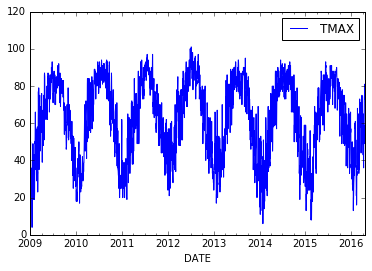

In [39]:
weather_data.plot(y=['TMAX'])

In [47]:
def get_max_temp_for_date(date):
    if isinstance(date, str):
        date = parse_datetime(date)
    date_slice = slice(date, date)
    data = weather_data[date_slice].TMAX
    return float(data) if not data.empty else None

In [48]:
get_max_temp_for_date('2013-04-13')

54.0

In [49]:
for april_date in DateFinder("april"):
    tmp = get_max_temp_for_date(april_date)
    print(april_date.date(), "~", tmp)

2016-04-25 ~ None
2015-04-27 ~ 54.0
2014-04-28 ~ 59.0
2013-04-29 ~ 65.0
2012-04-30 ~ 84.0
2011-04-25 ~ 74.0
2010-04-26 ~ 57.0


In [50]:
for month in months:
    print("%s:" % month)
    for next_date in DateFinder(month):
        tmp = get_max_temp_for_date(next_date)
        if tmp:
            print("\t%s ~ %.1f" % (next_date.date(), tmp))

Jan:
	2016-01-25 ~ 46.0
	2015-01-26 ~ 27.0
	2014-01-27 ~ 42.0
	2013-01-28 ~ 51.0
	2012-01-30 ~ 50.0
	2011-01-31 ~ 32.0
	2010-01-25 ~ 49.0
Feb:
	2016-02-29 ~ 57.0
	2015-02-23 ~ 19.0
	2014-02-24 ~ 34.0
	2013-02-25 ~ 46.0
	2012-02-27 ~ 58.0
	2011-02-28 ~ 63.0
	2010-02-22 ~ 40.0
Mar:
	2016-03-28 ~ 59.0
	2015-03-30 ~ 57.0
	2014-03-31 ~ 65.0
	2013-03-25 ~ 36.0
	2012-03-26 ~ 52.0
	2011-03-28 ~ 42.0
	2010-03-29 ~ 50.0
Apr:
	2015-04-27 ~ 54.0
	2014-04-28 ~ 59.0
	2013-04-29 ~ 65.0
	2012-04-30 ~ 84.0
	2011-04-25 ~ 74.0
	2010-04-26 ~ 57.0
May:
	2015-05-18 ~ 79.0
	2014-05-19 ~ 71.0
	2013-05-20 ~ 86.0
	2012-05-21 ~ 87.0
	2011-05-23 ~ 82.0
	2010-05-24 ~ 83.0
Jun:
	2015-06-29 ~ 66.0
	2014-06-30 ~ 87.0
	2013-06-24 ~ 87.0
	2012-06-25 ~ 80.0
	2011-06-27 ~ 83.0
	2010-06-28 ~ 85.0
Jul:
	2015-07-27 ~ 87.0
	2014-07-28 ~ 76.0
	2013-07-29 ~ 76.0
	2012-07-30 ~ 90.0
	2011-07-25 ~ 89.0
	2010-07-26 ~ 83.0
Aug:
	2015-08-31 ~ 86.0
	2014-08-25 ~ 87.0
	2013-08-26 ~ 90.0
	2012-08-27 ~ 84.0
	2011-08-29 ~ 78.0
	2010-08-3

# Part Three

### Predict the temperature of the 2016 May COhPy meeting

Use a model to predict temperatures for May 23, 2016

In [156]:
model = PolynomialModel(6)
params = model.make_params(c0=80, c1=-.1, c2=.5, c3=0, c4=0, c5=0, c6=0)

N = 100
x = np.arange(1, N + 2)
Y = []
for year in range(2010, 2015):
    date = datetime(year, 5, 22)
    Y.append(weather_data[date:date - timedelta(days=N):-1].TMAX)

Y = np.array(Y)
fit = model.fit(Y, params, x=x)
print(fit.fit_report(min_correl=0.25))


[[Model]]
    Model(polynomial)
[[Fit Statistics]]
    # function evals   = 19
    # data points      = 505
    # variables        = 7
    chi-square         = 60715.005
    reduced chi-square = 121.918
[[Variables]]
    c0:   79.0704397 +/- 3.891774 (4.92%) (init= 80)
    c1:  -1.08062101 +/- 1.030406 (95.35%) (init=-0.1)
    c2:   0.05991534 +/- 0.086410 (144.22%) (init= 0.5)
    c3:  -0.00190923 +/- 0.003152 (165.10%) (init= 0)
    c4:   3.0077e-05 +/- 5.60e-05 (186.05%) (init= 0)
    c5:  -2.3793e-07 +/- 4.76e-07 (199.89%) (init= 0)
    c6:   7.4759e-10 +/- 1.55e-09 (207.20%) (init= 0)
[[Correlations]] (unreported correlations are <  0.250)
    C(c5, c6)                    = -0.997 
    C(c4, c5)                    = -0.995 
    C(c3, c4)                    = -0.992 
    C(c2, c3)                    = -0.987 
    C(c4, c6)                    =  0.984 
    C(c3, c5)                    =  0.976 
    C(c1, c2)                    = -0.972 
    C(c2, c4)                    =  0.961 
   

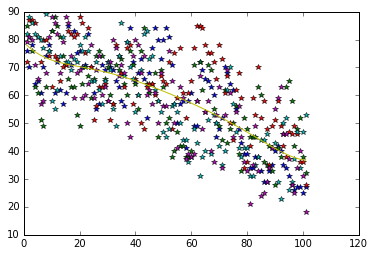

In [152]:
plt.plot(x, Y.T, '*')
plt.plot(x, model.eval(fit.params, x=x))


Well, that's not a good set of data!! Oh well, what is the value of the intercept?

In [155]:
fit.params['c0'].value

79.070439701712445

Final Prediction Answer: 79.1ºF